# 1. Slug Test - Pratt County

### Import packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import timflow.transient as tft

plt.rcParams["figure.figsize"] = [5, 3]

### Introduction and Conceptual Model

Consider the slug test conducted in Pratt County Monitoring Site, US, and reported by Butler (1998). 
A partially penetrating well is screened in unconsolidated alluvial deposits consisting of sand and gravel interbedded by clay. The total thickness of the aquifer is 47.87 m. The screen is located at 16.77 m depth and has a screen length of 1.52 m. The well radius is 0.125 m and the casing radius 0.064 m. The slug displacement is 0.671 m. The head change was recorded inside the well.

<img src="./figs/Pratt_County.png" style="width:400pt">

### Load data

In [11]:
data = np.loadtxt("data/slug.txt", skiprows=1)
to = data[:, 0] / 60 / 60 / 24  # convert time in seconds to days
ho = data[:, 1]  # m

### Parameters and model

In [13]:
rw = 0.125  # well radius, m
rc = 0.064  # well casing radius, m
L = 1.52  # screen length, m
b = 47.87  # aquifer thickness, m
zt = -16.77  # elevation to top of screen, m
H0 = 0.671  # head displacement in the well, m
zb = zt - L  # bottom of screen in m

The total volume if the slut is computed, as this is used as the instantaneous discharge for the well in `timflow`. 

In [16]:
Q = np.pi * rc**2 * H0 # instantaneous discharge
print(f"volume of slug: {Q:.5f} m^3")

volume of slug: 0.00863 m^3


The aquifer is represented by a three-layer model, one layer above the screen, one layer at interval of the screen top, and one layer below the screen.
A slug test is simulated by specify the instantaneous volume that is added to the well and by defining the well type `wbstype` as `"slug"`. 

In [17]:
ml = tft.Model3D(kaq=10, z=[0, zt, zb, -b], Saq=1e-4, kzoverkh=1, tmin=1e-6, tmax=0.01)
w = tft.Well(ml, xw=0, yw=0, rw=rw, rc=rc, tsandQ=[(0, -Q)], layers=1, wbstype="slug")
ml.solve()

self.neq  1
solution complete


### Estimate aquifer parameters 
The hydraulic conductivity and specific storage coeffient are calibrated. They are the same for all three layers. 

In [21]:
cal = tft.Calibrate(ml)
cal.set_parameter(name="kaq", layers=[0, 1, 2], initial=10)
cal.set_parameter(name="Saq", layers=[0, 1, 2], initial=1e-4)
cal.seriesinwell(name="obs", element=w, t=to, h=ho)
cal.fit(report=False)

........................
Fit succeeded.


In [22]:
display(cal.parameters.loc[:, ["optimal"]])
print("RMSE:", cal.rmse())

,optimal
kaq_0_2,6.048929
Saq_0_2,0.000213


RMSE: 0.002855685425383004


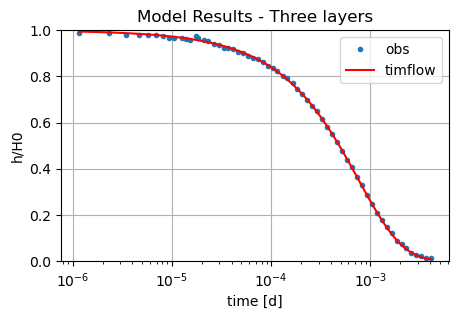

In [23]:
tm = np.logspace(np.log10(to[0]), np.log10(to[-1]), 100)
hm = ml.head(0, 0, tm, layers=1)
plt.semilogx(to, ho / H0, ".", label="obs")
plt.semilogx(tm, hm[-1] / H0, "r", label="timflow")
plt.ylim([0, 1])
plt.xlabel("time [d]")
plt.ylabel("h/H0")
plt.title("Model Results - Three layers")
plt.legend()
plt.grid()

### Comparison of results

The solution in `timflow` is compared with the KGS analytical model (Hyder et al. 1994) implemented in AQTESOLV (Duffield, 2007). Both models show similarly low RMSE values. However, the estimated hydraulic conductivity and specific storage parameters differ substantially.

In [10]:
t = pd.DataFrame(
    columns=["k [m/d]", "Ss [1/m]", "RMSE [m]"],
    index=["timflow", "AQTESOLV"],
)

t.loc["timflow"] = np.append(cal.parameters["optimal"].values.tolist(), cal.rmse())
t.loc["AQTESOLV"] = [4.034, 3.834e-04, 0.002976]

t_formatted = t.style.format(
    {"k [m/d]": "{:.2f}", "Ss [1/m]": "{:.2e}", "RMSE [m]": "{:.4f}"}
)
t_formatted

,k [m/d],Ss [1/m],RMSE [m]
timflow,6.05,2.13e-04,0.0029
AQTESOLV,4.03,3.83e-04,0.0030


## References
* Butler Jr., J.J. (1998), The Design, Performance, and Analysis of Slug Tests, Lewis Publishers, Boca Raton, Florida, 252p.
* Duffield, G.M. (2007), AQTESOLV for Windows Version 4.5 User's Guide, HydroSOLVE, Inc., Reston, VA.
* Hyder, Z., Butler Jr, J.J., McElwee, C.D. and Liu, W. (1994), Slug tests in partially penetrating wells, Water Resources Research 30, 2945–2957.